In [1]:
import cv2
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib

In [2]:
model = 'collective'
symmetric = False
nPosts = 3

if symmetric == True:
    data = 'SPP/symmetric_n' if model == 'collective' else 'NN/symmetric_n'
    prefix = 'coll_symmetric_' if model == 'collective' else 'symmetric_'
else:
    data = 'SPP/collective_n' if model == 'collective' else 'NN/flydata_n'
    prefix = 'coll_' if model == 'collective' else ''

tmin = 0
if symmetric == True:
    if nPosts < 4:
        tmax = 2000 if model == 'neural' else 5100
    else:
        tmax = 3000 if model == 'neural' else 5100
else:
    if nPosts < 4:
        tmax = 1200 if model == 'neural' else 5100
    else:
        tmax = 1900 if model == 'neural' else 5100
        
window_size = 600

df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/" + data + str(nPosts) + ".csv")
df.head()

,replicate,time,good_run,x,y,cue_reached
0,0,0,1,5.59224,499.770,-1
1,0,50,1,7.73565,500.295,-1
2,0,100,1,12.05770,500.001,-1
3,0,150,1,16.75220,499.884,-1
4,0,200,1,21.44280,499.849,-1


In [3]:
if symmetric:
    xs = np.array((df[' x'] - 500) / 100)
    df[' x'] = xs
else:
    xs = np.array(df[' x'] / 100)
    df[' x'] = xs
    
ys = np.array((df[' y'] - 500) / 100)
df[' y'] = ys

if model == 'neural':
    ts = df['time']
else:
    ts = df[' time']

xs = xs[ts < tmax]
ys = ys[ts < tmax]
ts = ts[ts < tmax]

if nPosts == 2:
    if symmetric:
        post0_x = 5.0*np.cos(np.pi)
        post0_y = 5.0*np.sin(np.pi)

        post1_x = 5.0*np.cos(0)
        post1_y = 5.0*np.sin(0)
    else:
        post0_x = 5.0*np.cos(np.pi/6)
        post0_y = -5.0*np.sin(np.pi/6)

        post1_x = 5.0*np.cos(np.pi/6)
        post1_y = 5.0*np.sin(np.pi/6)
elif nPosts == 3:
    if symmetric:
        post0_x = 5.0*np.cos(-2*np.pi/3)
        post0_y = 5.0*np.sin(-2*np.pi/3)

        post1_x = 5.0
        post1_y = 0.0

        post2_x = 5.0*np.cos(2*np.pi/3)
        post2_y = 5.0*np.sin(2*np.pi/3)
    else:
        post0_x = 5.0*np.cos(2*np.pi/9)
        post0_y = -5.0*np.sin(2*np.pi/9)

        post1_x = 5.0
        post1_y = 0.0

        post2_x = 5.0*np.cos(2*np.pi/9)
        post2_y = 5.0*np.sin(2*np.pi/9)
else:
    if symmetric:
        post0_x = -5.0
        post0_y = 0.0

        post1_x = 0.0
        post1_y = 5.0

        post2_x = 5.0
        post2_y = 0.0
        
        post3_x = 0.0
        post3_y = -5.0
    else:
        post0_x = 5.0*np.cos(2*np.pi/9)
        post0_y = -5.0*np.sin(2*np.pi/9)

        post1_x = 5.0
        post1_y = 0.0

        post2_x = 5.0*np.cos(2*np.pi/9)
        post2_y = 5.0*np.sin(2*np.pi/9)

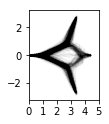

In [4]:
if nPosts == 2:
    if symmetric:
        fig, ax = plt.subplots(1,1,figsize=(2,2))
    else:
        fig, ax = plt.subplots(1,1,figsize=(post0_x/2.5,post1_y/1.25))
else:
    if symmetric:
        fig, ax = plt.subplots(1,1,figsize=(2,2))
    else:
        fig, ax = plt.subplots(1,1,figsize=(1.25,post2_x/2))
plt.scatter(xs, ys, c='black', s=1, alpha=0.01)
ax.set_aspect('equal')
if symmetric:
    if nPosts == 2:
        ax.set_xticks([-4,-2,0,2,4])
        ax.set_yticks([-4,-2,0,2,4])
    else:
        ax.set_xticks([-4,-2,0,2,4])
        ax.set_yticks([-4,-2,0,2,4])
else:
    if nPosts == 2:
        ax.set_xticks([0,1,2,3,4])
        ax.set_yticks([-2,-1,0,1,2])
        plt.xlim(0,post0_x)
        plt.ylim(post0_y,post1_y)
    else: 
        ax.set_xticks([0,1,2,3,4,5])
        #ax.set_yticks([-3,-2,-1,0,1,2,3])
        plt.xlim(0,5)
        plt.ylim(post0_y,post2_y)
    
fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + prefix + 'trajectories_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

In [5]:
nbins = 500
peak_threshold = 0.9

def density_map(x, y, stats=True):
    blur = (11, 11) if stats == True else (51, 51)
    
    if nPosts == 2:
        r = (
            [[-5, 5], [-5, 5]]
            if symmetric == True
            else [[0, post0_x], [post0_y, post1_y]]
        )
    elif nPosts == 3:
        r = (
            [[post0_x, post1_x], [post0_y, post2_y]]
            if symmetric == True
            else [[0, post1_x], [post0_y, post2_y]]
        )
    else:
        r = (
            [[-5, 5], [-5, 5]]
            if symmetric == True
            else [[0, post1_x], [post0_y, post2_y]]
        )
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    if nPosts == 2:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    else:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    tmp_img /= np.max(tmp_img)

    return tmp_img

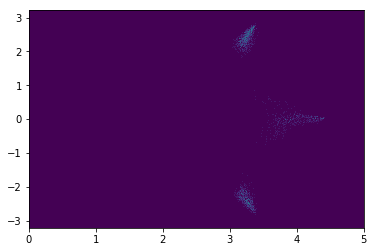

In [6]:
for idx,t in enumerate(range(tmin,tmax-window_size,10)):
    window_min = t
    window_max = t + window_size
    
    x = xs[(ts > window_min) & (ts < window_max)]
    y = ys[(ts > window_min) & (ts < window_max)]
    tmp_img = density_map(x, y, stats=False)
    
    if idx == 0:
        img = tmp_img
    else:
        img = np.fmax(tmp_img, img)
        
if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
elif nPosts == 3:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

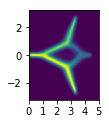

In [7]:
if nPosts == 2:
    if symmetric == True:
        fig, ax = plt.subplots(1,1, figsize=(2,2))
        plt.imshow(img, extent=[-5, 5, -5.0, 5.0])
        plt.xticks([-4,-2,0,2,4])
        plt.yticks([-4,-2,0,2,4])
    else:
        fig, ax = plt.subplots(1, 1, figsize=(post0_x/2.5,post1_y/1.25))
        plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
        plt.xticks([0,1,2,3,4])
elif nPosts == 3:
    if symmetric == True:
        fig, ax = plt.subplots(1,1, figsize=(3.75/2,post2_y/2))
        plt.imshow(img, extent=[post0_x, post1_x, post0_y, post2_y])
    else:
        fig, ax = plt.subplots(1, 1, figsize=(1.25,post2_x/2))
        plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])
        plt.xticks([0,1,2,3,4,5])
else:
    if symmetric == True:
        fig, ax = plt.subplots(1,1, figsize=(post2_x/2,post1_y/2))
        plt.imshow(img, extent=[-post2_x, post2_x, -post1_y, post1_y])
        plt.xticks([-4,-2,0,2,4])
    else:
        fig, ax = plt.subplots(1, 1, figsize=(1.25,post2_x/2))
        plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])
        plt.xticks([0,1,2,3,4,5])

fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + prefix + 'density_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

### Identify bifurcation point using a piecewise phase-transition function

#### Get first bifurcation point
Once you have this, you can draw a line segment bisecting the angle between the point and two targets. This will be the line about which you symmetrise to get the second bifurcation point

In [8]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)

def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

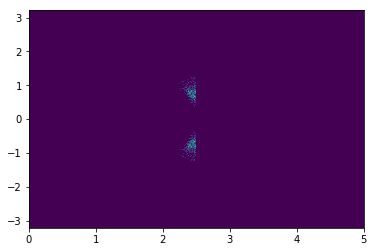

In [9]:
x_fit = []
y_fit = []
    
if nPosts == 2:
    if model == 'neural':
        bif_pt = 2.5
        params1 = [3, 1, 1]
    else:
        bif_pt = 1.2
        params1 = [1.5, 1, 1]
    
    x_sub = np.concatenate((xs, xs))
    y_sub = np.concatenate((ys, -ys))
    t_sub = np.concatenate((ts, ts))

    tmin = np.min(t_sub)
    tmax = np.max(t_sub)-100 if model == 'neural' else np.max(t_sub)-500
    for idx,t in enumerate(range(tmin,tmax,10)):
        window_min = t
        window_max = t + window_size

        x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
        y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
        tmp_img2 = density_map(x, y, stats=False)

        if idx == 0:
            tmp_img = tmp_img2
        else:
            tmp_img = np.fmax(tmp_img2, tmp_img)
    
    x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins
        + post1_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    for i in range(0,10):
        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
        )
        params1 = fit_params

else:
    if model == 'neural':
        bif_pt = 1
        params1 = [1.2, 1, 0.5]
        
        xs1 = xs[xs < 2.7]
        ys1 = ys[xs < 2.7]
        ts1 = ts[xs < 2.7]
    else:
        bif_pt = 0.8
        params1 = [1, 1, 0.5]
        
        xs1 = xs[xs < 2.5]
        ys1 = ys[xs < 2.5]
        ts1 = ts[xs < 2.5]

    x_sub = np.concatenate((xs1, xs1))
    y_sub = np.concatenate((ys1, -ys1))
    t_sub = np.concatenate((ts1, ts1))

    tmin = np.min(t_sub)
    tmax = np.max(t_sub)-100 if model == 'neural' else np.max(t_sub)-500
    for idx,t in enumerate(range(tmin,tmax,10)):
        window_min = t
        window_max = t + window_size

        x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
        y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
        tmp_img2 = density_map(x, y, stats=False)

        if idx == 0:
            tmp_img = tmp_img2
        else:
            tmp_img = np.fmax(tmp_img2, tmp_img)
            
    x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins
        + post2_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    for i in range(0,10):
        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
        )
        params1 = fit_params

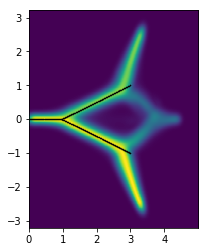

In [10]:
if nPosts == 2:
    fig, ax = plt.subplots(1, 1, figsize=(post0_x/2.5,post1_y/1.25))
    plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
else:
    plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

parameters = params1
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

offset=0.2 if model == 'neural' else 0.5
x = (
    np.arange(parameters[0], post0_x-offset, step_len)
    if nPosts == 2
    else np.arange(parameters[0], 3., step_len)
)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    ((parameters[2] * (x - parameters[0])) ** parameters[1], -(parameters[2] * (x - parameters[0])) ** parameters[1])
)

if nPosts != 2:
    bisector_xs = [params1[0], post2_x]
    bisector_ys = [
        0,
        np.tan(np.arctan2(post2_y, post2_x - params1[0]) / 2)
        * (post2_x - params1[0]),
    ]

plt.xticks([0,1,2,3,4])
plt.scatter(x1, y1, c="black", s=0.1)
plt.scatter(x2, y2, c="black", s=0.1)
    
if nPosts == 2:
    fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + prefix + 'density_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')

In [11]:
if nPosts == 2:
    print(
        "The bifurcation occurs at an angle",
        2 * np.arctan2(post1_y, post1_x - params1[0]) * 180 / np.pi,
    )
else:
    print(
        "The first bifurcation occurs at an angle",
        2 * np.arctan2(post2_y, post2_x - params1[0]) * 180 / np.pi,
    )

The first bifurcation occurs at an angle 96.38939242028479


#### Get the second bifurcation point
For this, you must center the trajectories about the bifurcation point, get a new heatmap and rotate this by the angle of the bisector line

In [12]:
# center points about the first bifurcation
cxs = xs - params1[0]
cys = ys
cts = ts

cpost0_x = post0_x - params1[0]
cpost1_x = post1_x - params1[0]
cpost2_x = post2_x - params1[0]

In [13]:
@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

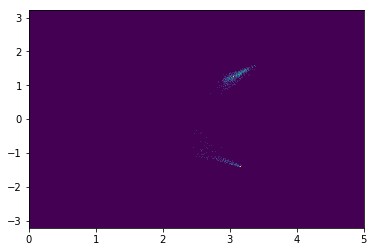

In [14]:
# clip all points to the left of and below 0 and points beyond post centers
ccxs = cxs[cxs > 0]
ccys = cys[cxs > 0]
ccts = cts[cxs > 0]
ccxs = ccxs[ccys > 0]
ccts = ccts[ccys > 0]
ccys = ccys[ccys > 0]

xy = np.concatenate((ccxs.reshape(-1, 1), ccys.reshape(-1, 1)), axis=1)
angle = np.full(
    ccxs.shape, np.arctan2(post2_y, post2_x - params1[0]) / 2
)
rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
rx, ry = parallel_rotate(xy, rmat).T

blur = (51,51)

r1 = [[0, post1_x], [post0_y, post2_y]]

tmin = np.min(ccts)
tmax = np.max(ccts)-100 if model == 'neural' else np.max(ccts)-500
for idx,t in enumerate(range(tmin,tmax,10)):
    window_min = t
    window_max = t + window_size
    
    x = rx[(ccts > window_min) & (ccts < window_max)]
    y = ry[(ccts > window_min) & (ccts < window_max)]
    tmp_img = density_map(x, y, stats=False)
    
    if idx == 0:
        tmp_img1 = tmp_img
    else:
        tmp_img1 = np.fmax(tmp_img1, tmp_img)

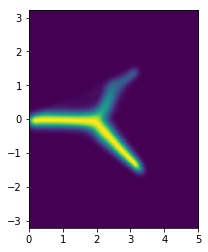

In [15]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])

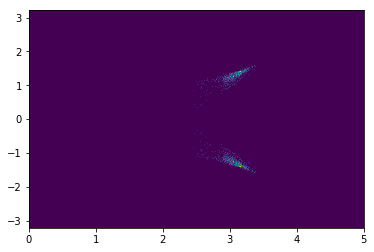

In [16]:
if model == 'neural':
    bif_pt = 2.2
    params2 = [2.5, 1, 0.5]
else:
    bif_pt = 1.8
    params2 = [2, 1, 0.5]

x_sub = np.concatenate((rx, rx))
y_sub = np.concatenate((ry, -ry))
t_sub = np.concatenate((ccts, ccts))

tmin = np.min(ccts)
tmax = np.max(ccts)-100 if model == 'neural' else np.max(ccts)-500
for idx,t in enumerate(range(tmin,tmax,10)):
    window_min = t
    window_max = t + window_size
    
    x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
    y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
    tmp_img = density_map(x, y, stats=False)
    
    if idx == 0:
        tmp_img1 = tmp_img
    else:
        tmp_img1 = np.fmax(tmp_img1, tmp_img)

x_fit = np.where(tmp_img1 > peak_threshold)[1] * post1_x / nbins
y_fit = (
    np.where(tmp_img1 > peak_threshold)[0] * (post0_y - post2_y) / nbins
    + post2_y
)

x_fit = x_fit
y_fit = np.abs(y_fit)
y_fit = y_fit[x_fit > bif_pt]
x_fit = x_fit[x_fit > bif_pt]

for i in range(0,10):
    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=params2, maxfev=10000
    )
    params2 = fit_params

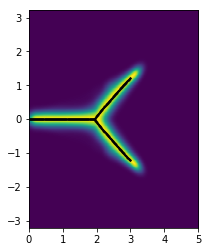

In [17]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])

parameters = params2
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = np.arange(parameters[0], 3, step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    ((parameters[2] * (x - parameters[0])) ** parameters[1], -(parameters[2] * (x - parameters[0])) ** parameters[1])
)

plt.scatter(x1, y1, c="black", s=1)
plt.scatter(x2, y2, c="black", s=1)

In [18]:
bif2 = np.array([params2[0], 0]).reshape(1, -1)
ang = angle[0]
rmat1 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]]).T
bif2 = parallel_rotate(bif2, rmat).T
bif2[0] += params1[0]

In [19]:
print(
    "The second bifurcation occurs at angle",
    (
        (
            np.arctan2(post2_y - bif2[1], post2_x - bif2[0])
            - np.arctan2(bif2[1] - post1_y, post1_x - bif2[0])
        )
        * 180
        / np.pi
    )[0],
)

The second bifurcation occurs at angle 93.6125826161468


In [20]:
x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))
bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
ang1 = np.full(
    x1.shape, -np.arctan2(post2_y, post2_x - params1[0]) / 2
)
rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
bx1 = bcx1 + params1[0]

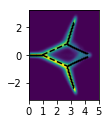

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(1.25,post2_x/2))
plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

step_len = 0.01
parameters = params2

bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
ang1 = np.full(x1.shape, -ang)
rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
bx1 = bcx1 + params1[0]

x = np.arange(parameters[0], 3.5, step_len) if model == 'neural' else np.arange(parameters[0], 3, step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1], 
        -(parameters[2] * (x - parameters[0])) ** parameters[1])
) 

bcxy2 = np.concatenate((x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
ang2 = np.full(x2.shape, -ang)
rmat2 = np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]]).T
bcx2, bcy2 = parallel_rotate(bcxy2, rmat2).T
bx2 = bcx2 + params1[0]

bx2 = np.concatenate((bx2, bx2))
bcy2 = np.concatenate((bcy2, -bcy2))

bcy2 = bcy2[bx2 < post1_x - 0.1]
bx2 = bx2[bx2 < post1_x - 0.1]

bx2 = bx2[np.abs(bcy2) < post2_y - 0.1]
bcy2 = bcy2[np.abs(bcy2) < post2_y - 0.1]

plt.plot(bx1, bcy1, linestyle="dashed", c="black")
plt.plot(bx1, -bcy1, linestyle="dashed", c="black")
plt.scatter(bx2, bcy2, c="black", s=0.1)

parameters = params1
step_len = 0.01

x1 = np.arange(5 * step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

# x = np.arange(parameters[0], 2.9, step_len)
# x2 = np.concatenate((x, x))
# y2 = np.concatenate(
#     (
#         (parameters[2] * (x - parameters[0])) ** parameters[1],
#         -(parameters[2] * (x - parameters[0])) ** parameters[1],
#     )
# )

plt.scatter(x1, y1, c="black", s=0.1)
# plt.scatter(x2, y2, c="black", s=0.1)
plt.xticks([0, 1, 2, 3, 4, 5])
    
fig.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + prefix + 'density_n' + str(nPosts) + '.pdf', dpi=600, bbox_inches='tight')